# BERT(Bidirectional Encoder Representations from Transformers)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 11 05:55:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# 라이브러리 로드

In [ ]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0

     |████████████████████████████████| 674 kB 6.9 MB/s 
     |████████████████████████████████| 1.2 MB 77.6 MB/s 
     |████████████████████████████████| 5.6 MB 35.3 MB/s 
     |████████████████████████████████| 895 kB 72.2 MB/s 
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 3.0 MB 67.5 MB/s 
     |████████████████████████████████| 454 kB 75.2 MB/s 
     |████████████████████████████████| 2.9 MB 72.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting

In [ ]:
import os
import re
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 로드

In [ ]:
tf.random.set_seed(111)
np.random.seed(111)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39

In [ ]:
import urllib.request

train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dif='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sentence, MAX_LEN):

  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True
  )

  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

학습할 데이터를 만드는 과정

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train_data['document'], train_data['label']), total=len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)
  except Exception as e:
    print(e)
    pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_token_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_token_type_ids)
train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

print("Sentences: {}\nLables: {}".format(len(train_movie_input_ids), len(train_data_labels)))

100%|██████████| 149995/149995 [00:36<00:00, 4153.58it/s]


Sentences: 149995
Lables: 149995


In [ ]:
idx = 5

input_id = train_movie_input_ids[idx]
attention_mask = train_movie_attention_masks[idx]
token_type_id = train_movie_token_type_ids[idx]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9247   8867  32158  23811    100    124  24982  17655   9757
  55511    122  23321  10954  24017  12030    129 106249  24974  30858
  18227    119    100    119    119    119   9353  30134  21789  12092
   9519 118671 119169    119    102      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 막 걸음마 [UNK] 3세부터 초등학교 1학년생인 8살용영화. [UNK]... 별반개도 아까움. [SEP] [PAD] [PAD] [PAD] [PAD]


# 모델 선언 및 컴파일

In [ ]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()

    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer= tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)

    return logits  

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=2)  

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

# Callback 선언

In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_naver_movie"

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join('./', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} Directory already exists\n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} Directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./tf2_bert_naver_movie Directory create complete



# 모델 학습

In [ ]:
history = cls_model.fit(train_movie_inputs, train_data_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[es_callback, cp_callback])

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.8114
Epoch 00001: val_accuracy improved from -inf to 0.84396, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 746s 199ms/step - loss: 0.4060 - accuracy: 0.8114 - val_loss: 0.3461 - val_accuracy: 0.8440
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8617
Epoch 00002: val_accuracy improved from 0.84396 to 0.85466, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 743s 198ms/step - loss: 0.3179 - accuracy: 0.8617 - val_loss: 0.3350 - val_accuracy: 0.8547
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.8899
Epoch 00003: val_accuracy improved from 0.85466 to 0.85583, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 743s 198ms/step - loss: 0.2632 - accuracy: 0.8899 - val_loss: 0

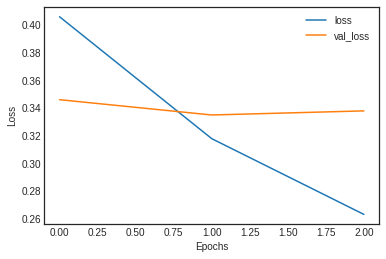

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# 모델 평가

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test_data['document'], test_data['label'])):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)
  except Exception as e:
    print(e)
    pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_token_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_token_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

49997it [00:12, 4133.28it/s]


In [ ]:
cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)

49/49 [==============================] - 61s 1s/step - loss: 0.3421 - accuracy: 0.8545


[0.3420540392398834, 0.8544512391090393]